In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew
import scipy as sp
from scipy import signal

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier

import yasa
from tqdm import tqdm
import xgboost as xgb

In [10]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [3]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


In [21]:
ytrain.head()

,y
0,2
1,2
2,2
3,2
4,2


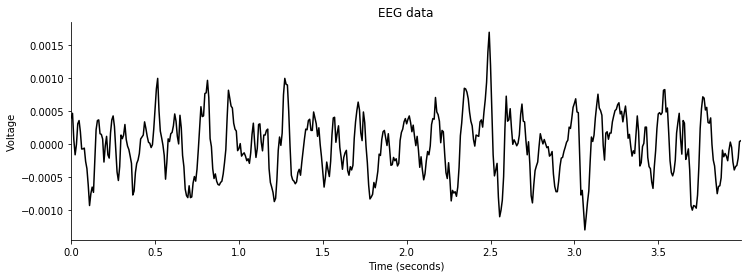

In [6]:
signal = xtrain_eeg1.iloc[0,:].values
# signal = xtrain_eeg1.values.ravel()

# Define sampling frequency and time vector
sf = 128.
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, signal, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

In [11]:
# Define function to extract features from eeg signal
# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_features_eeg(eeg_signal, frequency = 128):
    for i in (np.arange(eeg_signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(eeg_signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(eeg_signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(eeg_signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

def process_emg(emg_signal, fs = 128):
    # First remove offset by mean
    means = emg_signal.apply(np.mean, axis = 1)
    for i in np.arange(len(emg_signal)):
        emg_signal.iloc[i,:] = emg_signal.iloc[i,:] - means[i]
    
    # Second, filter signal with high and low pass filter settings
    high = 2.56/(fs/2) # these values can be changed
    low = 57.6/(fs/2) # these values can be changed
    b, a = sp.signal.butter(4, [high,low], btype='bandpass')
    for i in np.arange(len(emg_signal)):
        emg_signal.iloc[i,:] = sp.signal.filtfilt(b, a, emg_signal.iloc[i,:].values)
    
    # Third, rectify signal (absolute value)
    ## TRY REMOVING 
    emg_signal = emg_signal.abs()
    
    return emg_signal
    

def simple_statistics(sig, fs=128):
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(sig.shape) > 1) and (sig.shape[1]!=1):
        return np.array([np.mean(sig, axis=1), np.median(sig, axis=1),
                    np.std(sig, axis=1), np.max(sig, axis=1),
                    np.min(sig, axis=1), kurtosis(sig, axis=1),
                    skew(sig, axis=1)]).T
    else:
        print("Not Tested with this input!")
        return np.array([np.mean(sig), np.median(sig), np.std(sig),
                np.max(sig), np.min(sig), float(kurtosis(sig)),
                float(skew(sig))])

def vectorized_adv_stat(signal, fs=128):
    K_boundary = 10         # to be tuned
    t_fisher = 12          # to be tuned
    d_fisher = 40          # to be tuned
    features_num = 11
    threshold =  0.0009
    advanced_stats = np.zeros((signal.shape[0],features_num))
    print("Gathering advanced statistics...")
    feat_array = np.array([
                           pfd(signal),
                           hfd(signal, K_boundary),
                           np.sum((np.power(np.abs(signal),(-0.3)) > 20), axis=1),
                           np.sum((np.abs(signal)) > threshold, axis=1),
                           np.std(np.power(np.abs(signal),(0.05)), axis=1),
                           np.sqrt(np.mean(np.power(np.diff(signal, axis=1), 2), axis=1)),
                           np.mean(np.abs(np.diff(signal, axis=1)), axis=1),
                           np.mean(np.power(signal, 5), axis=1),
                           np.sum(np.power(signal, 2), axis=1)
                           ]).T
    return feat_array

def pfd(X):
    return pfd(X.values)

def pfd(X):
    """VECTORIZED!!! TESTED, matches the 1d time series output. Now accepts (nxd) matrices as input
    Compute Petrosian Fractal Dimension of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, the first order differential sequence of X (if D is provided,
           recommended to speed up)
    In case 1, D is computed using Numpy's difference function.
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.
    """
    n = X.shape[1]
    diff = np.diff(X, axis=1)
    N_delta = np.sum(diff[:, 1:-1] * diff[:, 0:-2] < 0, axis=1)
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))

def hfd(X, Kmax):
    return hfd(X.values, Kmax)

def hfd(X, Kmax):
    """ VECTORIZED!!! TESTED: Matches the for loop output. Can test easily comparing
    to the pyeeg.hfd() function. X now a (nxd) matrix.
    Compute Higuchi Fractal Dimension of a time series X. kmax
     is an HFD parameter
    """
    L = []
    x = []
    N = X.shape[1]
    for k in tqdm(range(1, Kmax)):
        # Lk = np.empty(shape=[0, ])
        Lk = np.empty(shape=[X.shape[0], 1])
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += np.abs(X[:, m + i * k] - X[:, m + i * k - k])
            Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
            Lmk = np.reshape(Lmk, (Lmk.shape[0], 1))
            Lk = np.hstack((Lk, Lmk))

        # Remove that first placeholder column of zeros in Lk:
        Lk = Lk[:, 1:]
        L.append(np.log(np.mean(Lk, axis=1)))
        x.append([np.log(float(1) / k), 1]) # Fix this!!!

    (p, _, _, _) = np.linalg.lstsq(x, L)
    return p[0]

In [12]:
xtrain1 = extract_features_eeg(xtrain_eeg1, 128)
xtrain2 = extract_features_eeg(xtrain_eeg2, 128)
xtrain2 = xtrain2.rename(columns = {"Delta": "Delta2", "Theta": "Theta2", "Alpha": "Alpha2",
                         "Beta": "Beta2", "Gamma": "Gamma2"})
xtrain_eeg = xtrain1.join(xtrain2)
xtrain_eeg.head()

,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,Gamma2
0,0.167779,0.589067,0.142509,0.084657,0.015988,0.145824,0.627337,0.140520,0.068544,0.017776
1,0.261716,0.384270,0.197637,0.141042,0.015335,0.274465,0.360708,0.230005,0.116119,0.018703
2,0.294706,0.191459,0.337027,0.158918,0.017890,0.360250,0.224307,0.271524,0.124966,0.018952
3,0.168293,0.581209,0.130216,0.105173,0.015109,0.129359,0.648551,0.135427,0.074995,0.011668
4,0.239408,0.542883,0.131650,0.076140,0.009920,0.118469,0.635031,0.127040,0.107246,0.012214


In [14]:
stats = simple_statistics(xtrain_eeg1)
stats1 = pd.DataFrame({"Std": stats[:,2], "Max": stats[:,3], "Min": stats[:,4], "Skew": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats1)
stats = simple_statistics(xtrain_eeg2)
stats2 = pd.DataFrame({"Std2": stats[:,2],"Max2": stats[:,3], "Min2": stats[:,4], "Skew2": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats2)

#xtrain_emg = process_emg(xtrain_emg)

stats = simple_statistics(xtrain_emg)
stats3 = pd.DataFrame({"Mean_emg": stats[:,0], "Median_emg": stats[:,1], "Std_emg": stats[:,2],
             "Max_emg": stats[:,3], "Min_emg": stats[:,4], "Kurtosis_emg": stats[:,5], "Skew_emg": stats[:,6]})
xtrain_eeg = xtrain_eeg.join(stats3)

stats = vectorized_adv_stat(xtrain_emg.values)
stats4 = pd.DataFrame({"x1": stats[:,0], "x2": stats[:,1], "x3": stats[:,2],
             "x4": stats[:,3], "x5": stats[:,4], "x6": stats[:,5], "x7": stats[:,6], "x9": stats[:,8]})
xtrain_eeg = xtrain_eeg.join(stats4)

xtrain_eeg.head()

Gathering advanced statistics...


100%|██████████| 9/9 [00:00<00:00,  8.30it/s]
/Users/andreasopedaleriksson/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/andreasopedaleriksson/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in power


,Delta,Theta,Alpha,Beta,Gamma,Delta2,Theta2,Alpha2,Beta2,Gamma2,...,Kurtosis_emg,Skew_emg,x1,x2,x3,x4,x5,x6,x7,x9
0,0.167779,0.589067,0.142509,0.084657,0.015988,0.145824,0.627337,0.140520,0.068544,0.017776,...,8.316864,-1.815205,1.034824,0.945445,502.0,0.0,0.041635,0.000013,0.000008,1.141335e-07
1,0.261716,0.384270,0.197637,0.141042,0.015335,0.274465,0.360708,0.230005,0.116119,0.018703,...,10.255864,-2.176539,1.035475,0.959493,504.0,0.0,0.048162,0.000011,0.000007,9.859970e-08
2,0.294706,0.191459,0.337027,0.158918,0.017890,0.360250,0.224307,0.271524,0.124966,0.018952,...,7.824936,-1.166946,1.034497,0.933330,509.0,0.0,0.040260,0.000010,0.000007,8.570733e-08
3,0.168293,0.581209,0.130216,0.105173,0.015109,0.129359,0.648551,0.135427,0.074995,0.011668,...,10.530290,-2.216652,1.036557,0.937956,505.0,0.0,0.040202,0.000011,0.000007,1.019762e-07
4,0.239408,0.542883,0.131650,0.076140,0.009920,0.118469,0.635031,0.127040,0.107246,0.012214,...,10.417868,-2.203634,1.033407,0.940074,507.0,0.0,0.040239,0.000010,0.000006,8.427712e-08


In [20]:
'''
## SVC APPROACH -- GRID-SEARCH CV

steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.1, 0.2, 0.3, 0.4, 0.5],  
              "classifier__class_weight": ["balanced"],
              "classifier__degree": [1,3,5]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 3)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)
'''

## AdaBoost approach

steps = [("scaler", StandardScaler()), ("classifier", AdaBoostClassifier())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__n_estimators": [50,100,200], "classifier__learning_rate": [0.08, 0.1, 0.12, 0.15, 0.3, 0.4, 0.5]}

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 3)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

'''

## XGB APPROACH -- GRID-SEARCH CV

steps = [("scaler", StandardScaler()), ("classifier", xgb.XGBClassifier())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__max_depth": [5,10,15,20],
              "classifier__n_estimators": [200],
              "classifier__learning_rate": [0.05,0.1,0.15,0.2],
              "classifier__max_features": [20,40,60]
             }

grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 3)

grid.fit(xtrain_eeg.values, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)
'''

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV] classifier__learning_rate=0.08, classifier__n_estimators=50 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=0.08, classifier__n_estimators=50, score=0.858, total=   9.2s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=50 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV]  classifier__learning_rate=0.08, classifier__n_estimators=50, score=0.851, total=  11.9s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=50 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.1s remaining:    0.0s


[CV]  classifier__learning_rate=0.08, classifier__n_estimators=50, score=0.776, total=  11.0s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=100 ....
[CV]  classifier__learning_rate=0.08, classifier__n_estimators=100, score=0.887, total=  19.3s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=100 ....
[CV]  classifier__learning_rate=0.08, classifier__n_estimators=100, score=0.898, total=  19.3s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=100 ....
[CV]  classifier__learning_rate=0.08, classifier__n_estimators=100, score=0.794, total=  19.2s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=200 ....
[CV]  classifier__learning_rate=0.08, classifier__n_estimators=200, score=0.898, total=  38.3s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=200 ....
[CV]  classifier__learning_rate=0.08, classifier__n_estimators=200, score=0.914, total=  38.1s
[CV] classifier__learning_rate=0.08, classifier__n_estimators=200 ....
[CV] 

[CV]  classifier__learning_rate=0.4, classifier__n_estimators=200, score=0.922, total=  35.7s
[CV] classifier__learning_rate=0.4, classifier__n_estimators=200 .....
[CV]  classifier__learning_rate=0.4, classifier__n_estimators=200, score=0.748, total=  35.9s
[CV] classifier__learning_rate=0.5, classifier__n_estimators=50 ......
[CV]  classifier__learning_rate=0.5, classifier__n_estimators=50, score=0.893, total=   9.1s
[CV] classifier__learning_rate=0.5, classifier__n_estimators=50 ......
[CV]  classifier__learning_rate=0.5, classifier__n_estimators=50, score=0.914, total=  10.5s
[CV] classifier__learning_rate=0.5, classifier__n_estimators=50 ......
[CV]  classifier__learning_rate=0.5, classifier__n_estimators=50, score=0.772, total=  12.1s
[CV] classifier__learning_rate=0.5, classifier__n_estimators=100 .....
[CV]  classifier__learning_rate=0.5, classifier__n_estimators=100, score=0.902, total=  17.6s
[CV] classifier__learning_rate=0.5, classifier__n_estimators=100 .....
[CV]  classif

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 24.6min finished


0.8626088953426653
{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 100}


'\n\n## XGB APPROACH -- GRID-SEARCH CV\n\nsteps = [("scaler", StandardScaler()), ("classifier", xgb.XGBClassifier())]\npipeline = Pipeline(steps = steps)\n\nparameters = {"classifier__max_depth": [5,10,15,20],\n              "classifier__n_estimators": [200],\n              "classifier__learning_rate": [0.05,0.1,0.15,0.2],\n              "classifier__max_features": [20,40,60]\n             }\n\ngrid = GridSearchCV(pipeline, parameters, cv = 3, scoring = \'balanced_accuracy\', verbose = 3)\n\ngrid.fit(xtrain_eeg.values, ytrain.values.ravel())\nprint(grid.best_score_)\nprint(grid.best_params_)\n'

Note: Compared performance with and without summary statistics. Marginally better with, 0.8596 vs 0.8541  
Update: Even better with summary statistics of emg added: 0.9066

With advanced stats  
EMG processing no absolute value: 0.90758 
EMG processing absolute value: 0.89972
EMG no processing: 0.90535

In [19]:
grid.cv_results_

{'mean_fit_time': array([ 4.03530534,  8.62019149, 20.25206637, 30.75107471,  3.86826197,
         9.39906406, 18.36061772, 27.34226958,  3.77062368, 10.05489167,
        20.54109375, 33.73195306,  4.07837629, 11.248957  , 21.26655046,
        29.26886559,  3.96131404,  9.73877199, 19.37861172, 29.6970307 ,
         3.97121469,  9.77654672, 19.63527822, 29.55363456]),
 'std_fit_time': array([0.1418878 , 0.09998253, 1.36028684, 1.21917061, 0.25201411,
        0.25688329, 0.33337944, 0.06337014, 0.11009464, 0.11055314,
        1.63424305, 3.07174949, 0.04871195, 0.84436834, 1.15965675,
        0.24155677, 0.00893552, 0.01898931, 0.0887009 , 0.30629621,
        0.02360507, 0.08183459, 0.06121324, 0.95147953]),
 'mean_score_time': array([0.11367893, 0.19799026, 0.43725189, 0.71393736, 0.11740502,
        0.22319635, 0.41673541, 0.71728905, 0.10854475, 0.2942249 ,
        0.45813839, 0.72428028, 0.12854338, 0.52442535, 0.46014524,
        0.66469423, 0.11054293, 0.24341305, 0.45362393, 0.67